In [1]:
import librosa
import librosa.display
import numpy as np

In [2]:
CNN_INPUT_SIZE = (128, 20)
DEFAULT_SR = 22050

In [3]:
def resize_axis(array, N):
    if(array.shape[1] > N):
        resized = array[:,:N]
    else:
        resized = np.lib.pad(array, ((0,0),(0,N - array.shape[1])),\
            'constant', constant_values=(np.min(array)))
    return resized

In [4]:
def extract_cnn_input(raw_audio):
    frame_length = min(2048, len(raw_audio))
    mel_spec = librosa.core.power_to_db(librosa.feature.melspectrogram(
        y=raw_audio, sr=DEFAULT_SR, n_fft=frame_length,
        hop_length=frame_length//4, n_mels=CNN_INPUT_SIZE[0])
    )
    # Truncate number of frames stored
    m = min(CNN_INPUT_SIZE[1], mel_spec.shape[1])
    N =20
    mell = resize_axis(mel_spec[:, 0:m], N)
    return mell

---

In [5]:
import os

def onehot(str):
    path = './Drum'
    kits = os.listdir(path)
    #kits.remove('.DS_Store')
    
    oh = []

    for kit in kits:
        if str == kit:
            oh.append(1)
        else:
            oh.append(0)
    
    return np.array(oh)

In [7]:
#path = 'Drum\Snare\9th Snare 38.wav'

y_label = None
x_label = None

drumkit_path = './Drum'
kits = os.listdir(drumkit_path)

for kit in kits:
    path = os.path.join(drumkit_path, kit)
    sounds = os.listdir(path)
    
    for sound in sounds:
        wavfile = os.path.join(path, sound)
        y, sr = librosa.load(wavfile)
        yt, index = librosa.effects.trim(y=y, top_db=30)
        yt = librosa.util.normalize(yt)
        k = extract_cnn_input(yt)
        k = np.expand_dims(k, axis=0)
        
        typ = onehot(kit)
        typ = np.expand_dims(typ, axis=0)
        
        if x_label is None:
            x_label = k.copy()
            y_label = typ.copy()
        else:
            x_label = np.concatenate((x_label, k), axis=0)
            y_label = np.concatenate((y_label, typ), axis=0)
        
        

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_label, y_label, test_size=0.2)

---

In [12]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 20,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
14/14 [==============================] - 2s 21ms/step - loss: 2.3486 - accuracy: 0.2656 - val_loss: 1.5511 - val_accuracy: 0.3125
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 1.1918 - accuracy: 0.6138 - val_loss: 1.1209 - val_accuracy: 0.5893
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.7328 - accuracy: 0.7679 - val_loss: 0.7418 - val_accuracy: 0.7589
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5559 - accuracy: 0.8036 - val_loss: 0.7204 - val_accuracy: 0.7679
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.3791 - accuracy: 0.8728 - val_loss: 0.6160 - val_accuracy: 0.8125
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.3154 - accuracy: 0.8817 - val_loss: 0.5678 - val_accuracy: 0.8036
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - loss: 0.2465 - accuracy: 0.9263 - val_loss: 0.5526 - val_accuracy: 0.8125
Epoch 8/20
14/14 [=

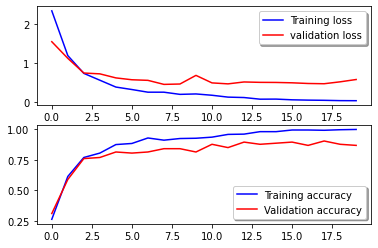

In [15]:
import matplotlib.pyplot as plt

# Plot the loss and accurac curves for training and validation

fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
ax[0].plot(history.history['val_loss'], color='r', label = "validation loss", axes = ax[0])
legend = ax[0].legend(loc='best', shadow = True)

ax[1].plot(history.history['accuracy'], color = 'b', label = "Training accuracy")
ax[1].plot(history.history['val_accuracy'], color = 'r', label = "Validation accuracy")
legend = ax[1].legend(loc = 'best', shadow = True)

In [16]:
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)

Y_Lab = np.argmax(y_test, axis = 1)

<AxesSubplot:>

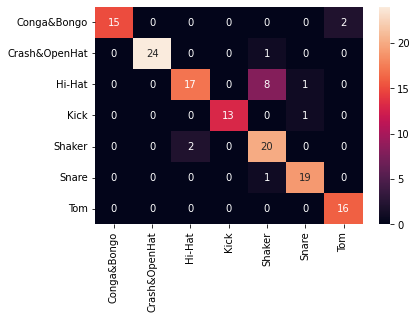

In [17]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

classes = ['Conga&Bongo', 'Crash&OpenHat', 'Hi-Hat', 'Kick', 'Shaker', 'Snare', 'Tom']

cm = pd.DataFrame(confusion_matrix(Y_Lab, Y_pred_classes), columns=classes, index=classes)
sns.heatmap(cm, annot=True)